# Tasks Sheet 4 – Linear and Logistic Regression

## Task 1: Linear Regression with trigonometric features

In this exercise, you will explore how **model complexity affects the performance** of a regression model.
You will generate synthetic data, fit linear regression models with trigonometric basis functions, and analyze train vs. test error to understand overfitting and generalization. In addition, you will compare the coefficients of determination $R^2$ and adjusted $R^2$.


**a)** Generate synthetic data and create a train–test split

- Create a dataset of 70 points by sampling values of $x$ between –3 and 3.
- Define the true underlying linear relationship  $y=0.3x$ + ε,  where ε is Gaussian noise with mean 0 and standard deviation 0.2. Use a local random seed of 42.
- Reshape the data so that it can be used in scikit-learn.
- Split the data into training and testing sets (70% / 30%) using the function [train_test_split( )](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Setting RNG
rng = np.random.RandomState(42)

In [3]:
# Create a dataset of 70 points by sampling values of x between -3 and 3.
X = rng.uniform(-3, 3, size=70)

In [4]:
# Define true underlying linear relationship
noise = rng.normal(loc=0, scale=0.2, size=70)
y = 0.3*X + noise

In [5]:
# Reshape x so that it can be used in scikit-learn
# Originally, the shape is (70,)
# We need to make it (70, 1)
X = X.reshape(-1, 1)
X.shape

(70, 1)

In [6]:
# Splitting into 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,random_state=42)

- **b)** Implement trigonometric feature maps and fit linear regression models.

- We consider models of the form $$ y \approx \sum_{k=1}^K \big(a_k \sin(kx) + b_k \cos(kx)\big).$$  Define a function `trig_features(X, K)` that, for a chosen integer $K$, constructs the corresponding trigonometric features  $\Phi(x) = [\sin(x), \cos(x), \sin(2x), \cos(2x), \dots, \sin(Kx), \cos(Kx)]$ and returns the design matrix that `LinearRegression()` needs.
- For each $K = 1, 2, \dots, 9$, transform the training and test data using `trig_features(X, K)` and fit a linear regression model using [`LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) (least squares).
- For each model, compute: Train MSE, Test MSE, RMSE, Generalization gap (test MSE – train MSE), train $R^2$, adjusted $R^2$.

In [7]:
# Define trig_features
def trig_features(X, K):
    phi = []

    for i in range(1, K+1):
        phi.append(np.sin(i * X))
        phi.append(np.cos(i * X))
    
    return np.column_stack(phi)

In [8]:
def train_and_evaluate(X_train, X_test, y_train, y_test, K):    
    results = {
        'train_mse': [],
        'test_mse': [],
        'train_rmse': [],
        'test_rmse': [],
        'train_r2': [],
        'adjusted_r2': []
    }

    for k in range(1, K + 1):
        phi_train = trig_features(X_train, k)
        phi_test = trig_features(X_test, k)

        model = LinearRegression()
        model.fit(phi_train, y_train)
        
        y_pred_train = model.predict(phi_train)
        y_pred_test = model.predict(phi_test)

        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_train, y_pred_train)

        results['train_mse'].append(mse_train)
        results['test_mse'].append(mse_test)
        results['train_rmse'].append(np.sqrt(mse_train))
        results['test_rmse'].append(np.sqrt(mse_test))
        results['train_r2'].append(r2)

        N = X_train.shape[0]
        p = phi_train.shape[1] 

        adj_r2 = 1 - ((1 - r2) * (N - 1) / (N - p - 1))
        results['adjusted_r2'].append(adj_r2)
    
    return results

In [9]:
K = 9
results = train_and_evaluate(X_train, X_test, y_train, y_test, K)

**c)** Plot Train vs. Test error as a function of model complexity

**Your goal:** Identify the typical U-shape of test error and observe how overfitting emerges when the feature space becomes too rich.

- Create a plot showing Train MSE and Test MSE for $K = 1,…,9.$
- Label the axes clearly and include a legend.

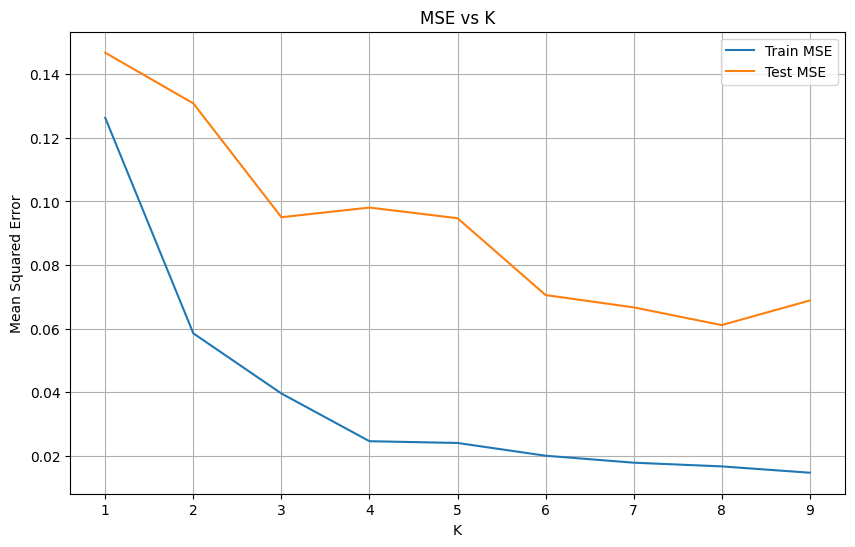

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, K + 1), results["train_mse"], label='Train MSE')
plt.plot(range(1, K + 1), results["test_mse"], label='Test MSE')

plt.title("MSE vs K")
plt.xlabel("K")
plt.ylabel("Mean Squared Error")

plt.legend() 
plt.grid(True)
plt.show()

**d)** Visualize Train $R^2$ and Adjusted $R^2$ (penalized model complexity):

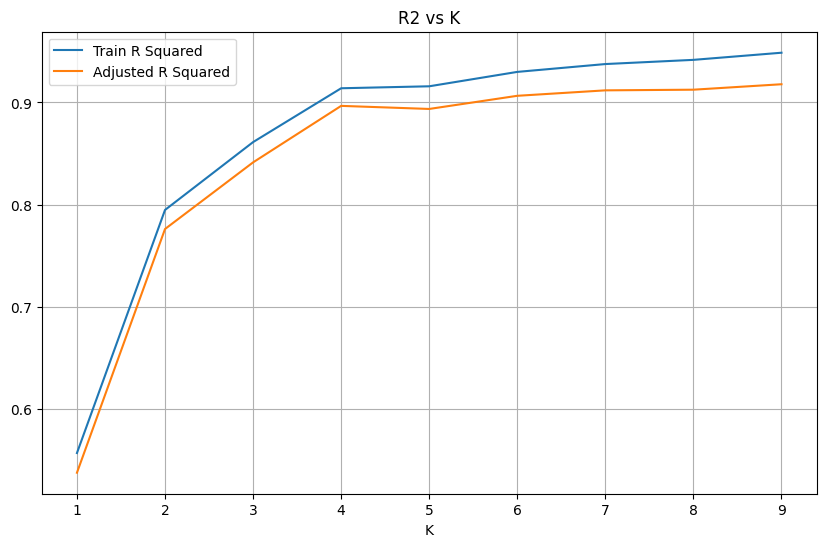

In [11]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, K + 1), results["train_r2"], label='Train R Squared')
plt.plot(range(1, K + 1), results["adjusted_r2"], label='Adjusted R Squared')

plt.title("R2 vs K")
plt.xlabel("K")

plt.legend() 
plt.grid(True)
plt.show()

**e)** Visualize the fitted trigonometric regression curve for an example model

**Your goal:** See how a more flexible model approximates the data and how this relates to the observed errors.

- Choose a specific value, e.g. $K = 6 $. Use the fitted model to predict values on a dense grid of $x$-values.
- Plot the training points, the test points, and the fitted trigonometric regression curve.

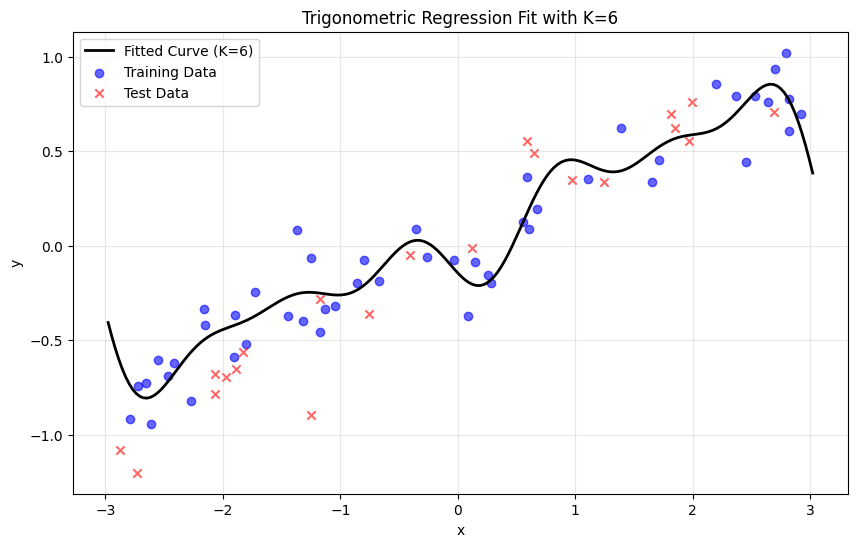

In [12]:
# Choosing K=6
K = 6

phi_train = trig_features(X_train, K)
model = LinearRegression()
model.fit(phi_train, y_train)

x_min = min(X_train.min(), X_test.min()) - 0.1
x_max = max(X_train.max(), X_test.max()) + 0.1
X_grid = np.linspace(x_min, x_max, 200).reshape(-1, 1)

phi_grid = trig_features(X_grid, K)

y_grid_pred = model.predict(phi_grid)

plt.figure(figsize=(10, 6))

plt.plot(X_grid, y_grid_pred, color='black', label=f'Fitted Curve (K={K})', linewidth=2)

plt.scatter(X_train, y_train, color='blue', alpha=0.6, label='Training Data')
plt.scatter(X_test, y_test, color='red', alpha=0.6, marker='x', label='Test Data')

plt.title(f"Trigonometric Regression Fit with K={K}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Task 2: Logistic Regression on Dataset (`heart.dat`)

**Goal.** Apply logistic regression to classify presence or absence of heart disease.

### Dataset "heart.dat"

Load the dataset "heart.dat" local on your computer. Make sure heart.dat is in the same folder as this notebook.

**Features used (six real-valued per UCI description):**  
1 (age), 4 (resting blood pressure), 5 (serum cholesterol), 8 (maximum heart rate), 10 (oldpeak/ST depression), 12 (number of major vessels).

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Make sure heart.dat is in the same folder as this notebook
df = pd.read_csv("heart.dat", sep=r"\s+", header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


- **Tasks:**

- **a) (i)** Display the shape of the raw data.  
  **(ii)** The class label is stored in the last column, where 1 = absence of disease and 2 = presence of disease. For binary classification, convert these labels to 0 and 1 as follows: absence → 0, presence → 1. You can use the function [`pandas.DataFrame.astype()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html).

- **b) (i)** Split the data into 70% train / 30% test (stratified). Use the function [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).  
  **(ii)** Display the shapes of the train and test data: (rows, columns).
- **c)** Train a logistic regression model (with standardization).
- **d)** Count the number of misclassifications on the training set and report the test 0–1 loss (error rate).
- **e)** Decide whether the training set is linearly separable.

In [ ]:
# a) (i)
df.shape

(270, 14)

In [ ]:
# a) (ii)
df[13] = (df[13]).astype("int")

In [33]:
# b) (i)
X = df.iloc[:, 0:13]
y = df.iloc[:, 13]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)

In [ ]:
# (ii)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (189, 13)
X_test shape:  (81, 13)
y_train shape: (189,)
y_test shape:  (81,)


In [37]:
# c)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression())
])

pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

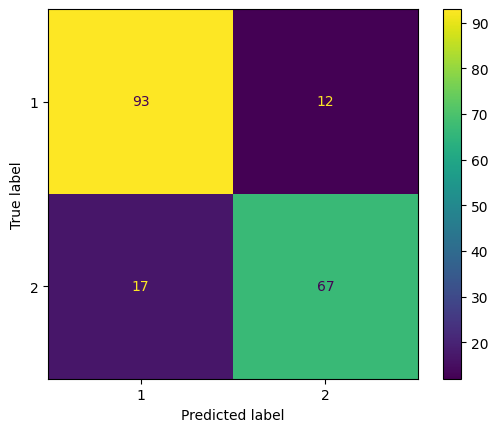

In [49]:
# d)
cm = confusion_matrix(y_train, y_pred_train, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

disp.plot()
plt.show()

Number of Misclassifications on Training Data is 12 + 17 = 29

In [ ]:
# e)
